# Quantum Kernels & Feature Maps

This notebook follows along and tries to reproduce the main results from [1].

In [23]:
from typing import Callable, Dict, Optional

##  Data

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets


def make_datasets(n_samples: int, training_pct: Optional[float] = None, seed: Optional[int] = None) -> Dict:
    """
    Creates the 4 datasets (circles, moons, exp, and xor) which consist of n_samples of 2-dimensional X data
    and the corresponding binary classification labels as y. If `training_pct` is None, X and y data is
    returned for each dataset; otherwise, the datasets returned are split into 'train' and 'test' partitions
    based on the training/test split percentage. 

    Args:
        n_samples (int): number of samples to generate from each dataset distribution
        training_pct (Optional[float], optional): Training/test split percentage. Defaults to None.
        seed (_type_, optional): Random seed for the data sampling. Defaults to Optional[int]=None.

    Returns:
        Dict: dictionary of the datasets
    """
    # Set numpy's random seed
    if seed is not None:
        np.random.seed(seed)

    # Make datasets
    circles = sklearn.datasets.make_circles(n_samples=n_samples, factor=0.3, noise=0.1, random_state=seed)
    moons = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.13, random_state=seed)
    xor = np.array([np.random.random(n_samples)*2-1, np.random.random(n_samples)*2-1])
    xor = tuple([xor.T, ((xor[0]<0) & (xor[1]>0)) | ((xor[0]>0) & (xor[1]<0)) + 0])
    exp = np.array([np.random.random(n_samples), np.random.random(n_samples)])
    exp = tuple([exp.T*2-1, (exp[1]>(0.1*(10.33**(exp[0]))))+0])

    if training_pct is None:
        ds = {
            'circles': {
                'X': circles[0],
                'y': circles[1]
            },
            'exp': {
                'X': exp[0],
                'y': exp[1]
            },
            'moons': {
                'X': moons[0],
                'y': moons[1]
            },
            'xor': {
                'X': xor[0],
                'y': xor[1]
            }
        }

    else:
        train_test_split_idx = int(n_samples*training_pct)
        ds = {
            'circles': {
                'train': {
                    'X': circles[0][0:train_test_split_idx, :],
                    'y': circles[1][0:train_test_split_idx]
                    },
                'test': {
                    'X': circles[0][train_test_split_idx:, :],
                    'y': circles[1][train_test_split_idx:]
                }
            },
            'exp': {
                'train': {
                    'X': exp[0][0:train_test_split_idx, :],
                    'y': exp[1][0:train_test_split_idx]
                },
                'test': {
                    'X': exp[0][train_test_split_idx:, :],
                    'y': exp[1][train_test_split_idx:]
                }
            },
            'moons': {
                'train': {
                    'X': moons[0][0:train_test_split_idx, :],
                    'y': moons[1][0:train_test_split_idx]
                },
                'test': {
                    'X': moons[0][train_test_split_idx:, :],
                    'y': moons[1][train_test_split_idx:]
                }
            },
            'xor': {
                'train': {
                    'X': xor[0][0:train_test_split_idx, :],
                    'y': xor[1][0:train_test_split_idx]
                },
                'test': {
                    'X': xor[0][train_test_split_idx:, :],
                    'y': xor[1][train_test_split_idx:]
                }
            }
        }

    return ds

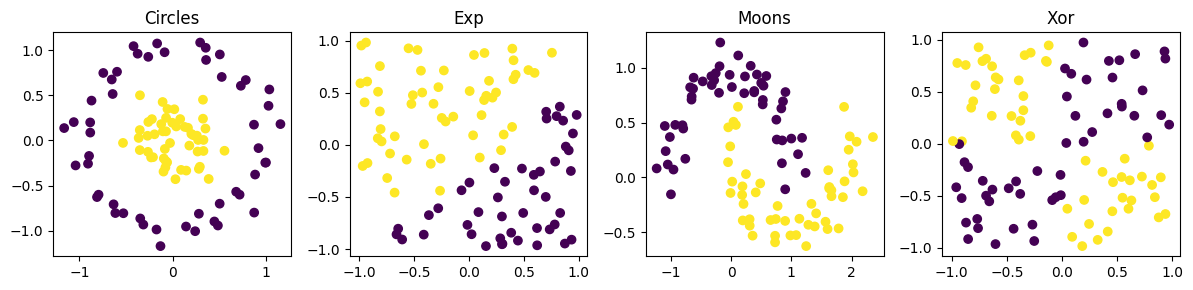

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

dataset = make_datasets(n_samples=100, seed=42)
DATASET_NAMES = list(dataset.keys())

axs[0].scatter(dataset['circles']['X'][:, 0], dataset['circles']['X'][:, 1], c=dataset['circles']['y'])
axs[1].scatter(dataset['exp']['X'][:, 0], dataset['exp']['X'][:, 1], c=dataset['exp']['y'])
axs[2].scatter(dataset['moons']['X'][:, 0], dataset['moons']['X'][:, 1], c=dataset['moons']['y'])
axs[3].scatter(dataset['xor']['X'][:, 0], dataset['xor']['X'][:, 1], c=dataset['xor']['y'])
axs[0].set_title('Circles')
axs[1].set_title('Exp')
axs[2].set_title('Moons')
axs[3].set_title('Xor')

plt.tight_layout()
plt.show()

## Encoding Functions

Now we'll implement different quantum feature maps based on the set of encoding functions given in [1], listed below:

1. $\phi_1(\bm{x}) = x_1, \phi_2(\bm{x}) = x_2, \phi_{1,2}(\bm{x}) = \pi x_1x_2$<br><br>
2. $\phi_1(\bm{x}) = x_1, \phi_2(\bm{x}) = x_2, \phi_{1,2}(\bm{x}) = \frac{\pi}{2}(1-x_1)(1-x_2)$<br><br>
3. $\phi_1(\bm{x}) = x_1, \phi_2(\bm{x}) = x_2, \phi_{1,2}(\bm{x}) = exp(\frac{|x_1 - x_2|^2}{8/ln(\pi)})$<br><br>
4. $\phi_1(\bm{x}) = x_1, \phi_2(\bm{x}) = x_2, \phi_{1,2}(\bm{x}) = \frac{\pi}{3cos(x_1)cos(x_2)}$<br><br>
5. $\phi_1(\bm{x}) = x_1, \phi_2(\bm{x}) = x_2, \phi_{1,2}(\bm{x}) = \pi cos(x_1)cos(x_2)$<br><br>

We'll set up a mapping (dictionary) of our feature map functions below so we can easily loop through all of them for each of our experiments.

In [26]:
from math import pi

# Dictionary of encoding functions that returns function of x1 and x2
encoding_fns = {
    'encoding_fn_1': lambda x1, x2: pi*x1*x2,
    'encoding_fn_2': lambda x1, x2: (pi/2)*(1-x1)*(1-x2),
    'encoding_fn_3': lambda x1, x2: np.exp(((x1-x2)*(x1-x2))/(8/np.log(pi))),
    'encoding_fn_4': lambda x1, x2: (pi)/(3*np.cos(x1)*np.cos(x2)),
    'encoding_fn_5': lambda x1, x2: pi*np.cos(x1)*np.cos(x2)
}

## Paramaterized Quantum Circuit

Now we need to set up a parameterized quantum circuit to implement our custom feature map. Following [1], we will build a 2-qubit circuit composed on 3 phase shift gates and 2 CNOT gates. When we actually use this circuit to compute our kernel functions, we will bind our actual data values.

In [27]:
from qiskit.circuit.library import PauliFeatureMap
from functools import partial

def param_circuit(encoding_fn: Callable) -> PauliFeatureMap:
    """
    Returns a PauliFeatureMap parameterized quantum circuit that encodes
    the given encoding function.

    Args:
        encoding_fn (Callable): encoding function of signiture (x1, x2) -> x_1,2

    Returns:
        PauliFeatureMap: feature map
    """
    # First define a custom data map based off a given encoding function
    def custom_data_map_func(func, x):
        coeff = x[0] if len(x) == 1 else func(x[0], x[1])
        return coeff

    # Then use the partial function to freeze the encoding function
    data_map_func = partial(custom_data_map_func, encoding_fn)
    return PauliFeatureMap(feature_dimension=2, reps=1, entanglement='linear', alpha=1.0, data_map_func=data_map_func)

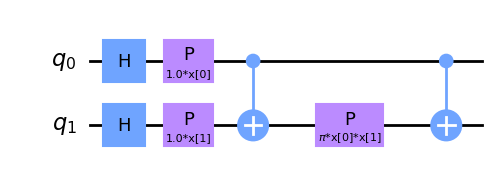

In [28]:
param_circuit(encoding_fn=encoding_fns['encoding_fn_1']).decompose().draw()

Note: The paper's circuit has 3 phase shift gates that have _negative_ parameters, ie $-x_1, -x_2, -\phi_{1, 2}(x_1, x_2)$ but qiskit kept throwing an error when I tried to use the new QuantumFidelityKernel code. When I use the deprecated code that uses opflow, it works fine. However, in order to migrate to newer implementations, I had issues with the negative sign. I don't think this should make any difference though.

## Quantum Kernel Setup

The last thing we need to setup is a function that will actually compute our kernel matrices given the quantum circuit, a feature map function, and data. We can set this up as shown below such that we can pass everything in as an argument which makes it easy to run for either test or training data, for each feature map, and for each dataset.

In [29]:
from qiskit import opflow

# Qiskit code throws deprecation warning when we use the calculate_kernel_old function
import warnings
warnings.filterwarnings('ignore')


## This function is now deprecated due to the deprecation of opflow.
def calculate_kernel_old(
        feature_map: PauliFeatureMap, train_X: np.ndarray, test_X: Optional[np.ndarray] = None
    ) -> np.ndarray:
    """
    Calculates the kernel matrix given the feature map and training and/or testing data.
    If only training data is provided, it computes the inner product of the training data with itself;
    otherwise it computes the fidelities between the training and testing data.

    Args:
        feature_map (PauliFeatureMap): PauliFeatureMap / Quantum circuit of the feature map
        train_X (np.ndarray): training data array, M x N, where M is the number of samples
            and N is the number of features
        test_X (Optional[np.ndarray], optional): test data array, M x N, where M is the
            number of test samples and N is the number of features. Defaults to None.

    Returns:
        np.ndarray: kernel matrix
    """
    # If no test data is provided, then calculate inner product of training data
    # with self. Otherwise, calculate inner products of test data with training
    if test_X is None:
        test_X = train_X

    # Use Operator Flow to create a list of feature map circuits,
    # parameterized by each data point
    train_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(train_X).tolist()))
        )
    test_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(test_X).tolist()))
        )
    
    # Compute the square of the conjugate inner product of the feature
    # map circuits: the kernel matrix
    kernel = np.abs(
        (~test_circuits.to_matrix_op() @ train_circuits.to_matrix_op()).eval()
    )**2
    
    return kernel

In [30]:
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# New implementation using the new FidelityQuantumKernel class which
# reproduces the exact results of the 'calculate_kernel_old' function
def calculate_kernel(
        feature_map: PauliFeatureMap,
        train_X: np.ndarray,
        test_X: Optional[np.ndarray] = None,
        shots: Optional[int] = None,
        sampler_seed: Optional[int] = None,
        backend: str = 'qasm_simulator'
    ) -> np.ndarray:
    """
    Simulates or calculates the kernel matrix given the feature map and training and/or testing data.
    If only training data is provided, it computes the inner product of the training data with itself;
    otherwise it computes the fidelities between the training and testing data. If `shots` is None, 
    then it calculates the probabilities. Otherwise, it samples the number of `shots` from the multinomial
    distribution to compute the kernel matrix.

    Args:
        feature_map (PauliFeatureMap): PauliFeatureMap / Quantum circuit of the feature map
        train_X (np.ndarray): training data array, M x N, where M is the number of samples
            and N is the number of features
        test_X (Optional[np.ndarray], optional): test data array, M x N, where M is the
            number of test samples and N is the number of features. Defaults to None.
        shots (Optional[int], optional): Number of shots for the sampler. If none is provided,
            then it computes the probabilities. Defaults to None.
        sampler_seed (Optional[int], optional): Random seed for the sampler; is ignored if
            `shots` is None. Defaults to None.
        backend (str, optional): Quantum backend to use. Defaults to 'qasm_simulator'.

    Returns:
        np.ndarray: kernel matrix
    """
    sampler = Sampler(options=dict(shots=shots, seed=sampler_seed, backend=backend))
    fidelity = ComputeUncompute(sampler=sampler)
    adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

    if test_X is None:
        kernel = adhoc_kernel.evaluate(x_vec=train_X)
    else:
        # Note that when passing both training & testing data, your TESTING data now becomes
        # the new x_vec argument and your training data is passed as y_vec. If reversed, your
        # kernel matrix will be transposed
        kernel = adhoc_kernel.evaluate(x_vec=test_X, y_vec=train_X)
    
    return kernel

## Calculations & Results

The code below will actually run our computations all the way through and store the results in our variables above. This process will first compute our kernel matrices and then pass those values to the (classical) scikit-learn support vector machine model to fit. Then it is scored on our training data and testing data and the accuracy results are saved. The paper's method runs through this on a datset with 20 datapoints 5 times (5 cross fold validation). However, I will repeat for 30 in order to validate the statistical significance of the results obtained.

In [38]:
import xarray as xr
from sklearn.svm import SVC

# Store results
cv_num = 30
results_train = np.empty((cv_num, len(DATASET_NAMES), len(encoding_fns)))
results_test = np.empty((cv_num, len(DATASET_NAMES), len(encoding_fns)))

# Define all the settings for running this exactly as the paper (except random seeds)
training_pct = 0.5
N = 40
c = 10e10
data_seed = 111720231
sampler_seed = 111720232
shots = 10000
backend='qasm_simulator'


for cv_id in np.arange(cv_num):
    datasets = make_datasets(n_samples=N, training_pct=training_pct, seed=data_seed+cv_id)
    for ef_idx, encoding_fn in enumerate(encoding_fns.values()):
        for ds_idx, dataset in enumerate(datasets):
            # First, precompute our kernels
            feature_map = param_circuit(encoding_fn)

            train_kernel = calculate_kernel(
                feature_map=feature_map,
                train_X=datasets[dataset]['train']['X'],
                shots=shots,
                sampler_seed=sampler_seed,
                backend=backend
            )
            test_kernel = calculate_kernel(
                feature_map=feature_map,
                train_X=datasets[dataset]['train']['X'],
                test_X=datasets[dataset]['test']['X'],
                shots=shots,
                sampler_seed=sampler_seed,
                backend=backend
            )

            # Then fit our support vector classifier
            model = SVC(kernel='precomputed', C=c)
            model = model.fit(train_kernel, datasets[dataset]['train']['y'])

            # Lastly, score our training accuracy and test accuracy and store results
            train_acc = model.score(train_kernel, datasets[dataset]['train']['y'])
            test_acc = model.score(test_kernel, datasets[dataset]['test']['y'])
            results_train[cv_id][ds_idx][ef_idx] = train_acc
            results_test[cv_id][ds_idx][ef_idx] = test_acc

results_ds = xr.Dataset(
    data_vars={
        "train":(["cv_id", "dataset", "feature_map"], results_train),
        "test": (["cv_id", "dataset", "feature_map"], results_test)
    },
    coords={"cv_id": np.arange(cv_num), "dataset": DATASET_NAMES, "feature_map": list(encoding_fns.keys())},
    attrs={"n_samples": N, "training_pct": training_pct}
).transpose("cv_id", "feature_map", "dataset")

In [39]:
# Training results
results_ds.mean("cv_id").train.to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,1.0,1.0,1.0,1.0
encoding_fn_2,1.0,1.0,1.0,1.0
encoding_fn_3,1.0,1.0,1.0,1.0
encoding_fn_4,1.0,1.0,1.0,1.0
encoding_fn_5,1.0,1.0,1.0,1.0


In [40]:
# Test results
results_ds.mean("cv_id").test.to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,0.926667,0.865000,0.755000,0.890000
encoding_fn_2,0.928333,0.881667,0.848333,0.806667
encoding_fn_3,0.983333,0.908333,0.765000,0.796667
encoding_fn_4,0.991667,0.921667,0.886667,0.761667
encoding_fn_5,0.998333,0.906667,0.948333,0.806667


In [51]:
# Standard deviation of the cross fold validation results
results_ds.std("cv_id").test.to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,0.073862,0.101776,0.108282,0.075719
encoding_fn_2,0.066687,0.096162,0.087066,0.085375
encoding_fn_3,0.037268,0.074256,0.099289,0.099107
encoding_fn_4,0.022669,0.070336,0.099944,0.099736
encoding_fn_5,0.008975,0.073862,0.056984,0.097240


In [43]:
# Display the encodidng functions that perform the max for each dataset
results_ds.test.mean("cv_id").idxmax("feature_map").to_pandas()

dataset
circles    encoding_fn_5
exp        encoding_fn_4
moons      encoding_fn_5
xor        encoding_fn_1
dtype: object

In [44]:
# Display the average accuracies across all feature maps per dataset
results_ds.test.mean(["cv_id", "feature_map"]).to_pandas()

dataset
circles    0.965667
exp        0.896667
moons      0.840667
xor        0.812333
dtype: float64

Qualitatively, we can look at our test results and see how well the kernels do on each dataset and make some observations. First, we see that encoding 5 performs the best for the circles dataset, encoding 4 performs best for the exponential dataset, encoding 5 performs best for the moons dataset, and encoding 1 performs best for the xor dataset. Overall, it looks like the xor dataset is the most challenging for the quantum kernels followed by the moons. The circles dataset seems the easiest for the quantum kernels to linearly separate followed by the exponential dataset.

The paper observes the best training/test accuracy from encoding 1 on the xor dataset which is also observed here. The paper also points out that encoding 4 has the highest _training_ accuracy on the exponential dataset, but encoding 2, 3, and 5 perform better on the test dataset in the paper so I don't feel like this is a very strong claim. However, my results above do show that encodings 4 performs the best on the exponential dataset.

## Statistical Results Analysis

The paper makes some claims about which encoding functions / feature maps perform better on which dataset so this section will statistically analyze that claim to see if there is significance in the accuracies achieved by the different kernels. First we will do an ANOVA test on the sets of 30 cross fold validation accuracies obtained by each feature map for a dataset to see if we see equal means/variances or if one stands out. We are assuming, under the law of large numbers that our cross fold validations accuraces form a normal distribution about the true mean, the datapoints are independent, and that the variances are about equal.

In [50]:
import pandas as pd
import scipy.stats as ss

# Store anova results
anova_results = np.empty((len(DATASET_NAMES), 2))

# first lets do the anova test for each dataset
for ds_idx, dataset in enumerate(DATASET_NAMES):
    samples = [results_ds.test.sel(dataset=dataset, feature_map=feature_map) for feature_map in list(encoding_fns.keys())]
    f_stat, pval = ss.f_oneway(*samples)
    anova_results[ds_idx][0] = f_stat
    anova_results[ds_idx][1] = pval


# set significant level
alpha = 0.05

anova_results_df = pd.DataFrame(anova_results, index=DATASET_NAMES, columns=['F Statistic', 'P-value'])
anova_results_df['Significant?'] = anova_results_df['P-value'] < alpha
anova_results_df

,F Statistic,P-value,Significant?
circles,15.157397,2.240096e-10,True
exp,2.131686,7.981980e-02,False
moons,22.939334,1.061801e-14,True
xor,7.644224,1.287250e-05,True


We see that not all the results show significantly different means for all the datasets above across the set of feature maps. Let's now loop through each dataset and do a pairwise comparison of each feature map.

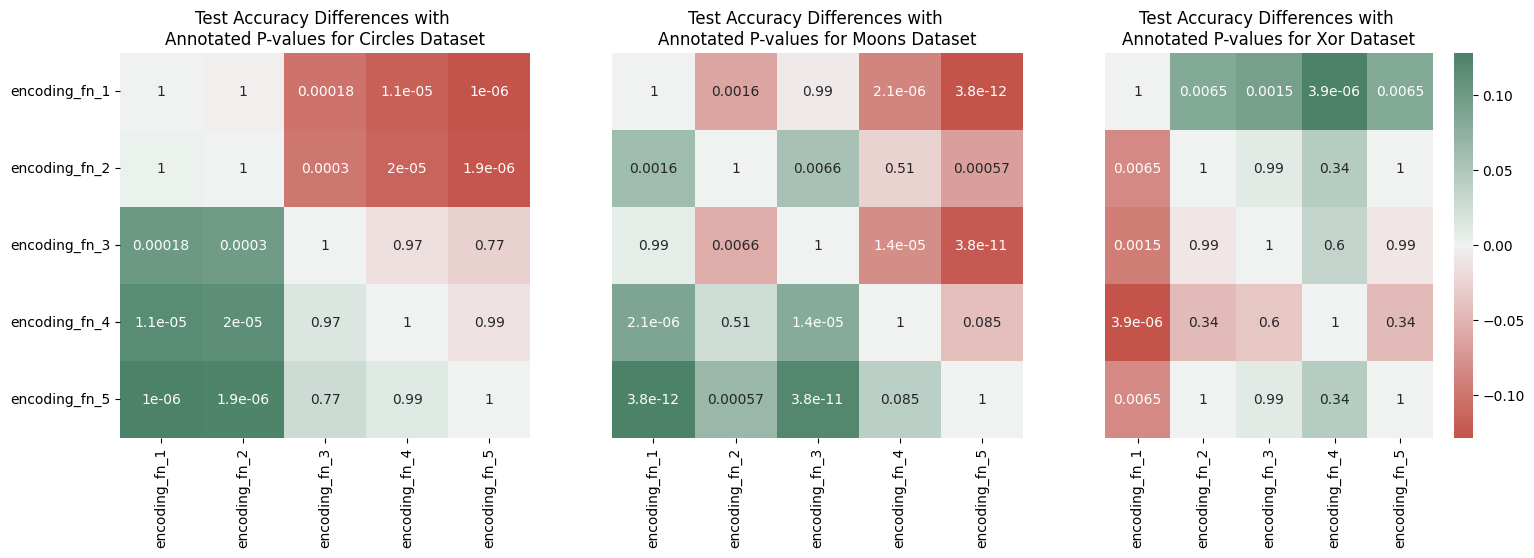

In [125]:
import seaborn as sns

# plot the pvalues of the pairwise comparisons of feature maps for only the significant ANOVA datasets
num_sig_datasets = np.sum(anova_results_df['Significant?'])
fig, axs = plt.subplots(nrows=1, ncols=num_sig_datasets, figsize=(18, 5))

i = 0
for dataset in DATASET_NAMES:
    if anova_results_df.loc[dataset]['Significant?']:
        # First, calculate the differences in the mean test accuracies scored between all feature maps
        fm_results = results_ds.test.sel(dataset=dataset).mean('cv_id').values
        acc_diffs = -1*np.subtract(*np.meshgrid(fm_results, fm_results))

        # Next, calculate the pairwise significances in those differences using Tukey's HSD test
        samples = [results_ds.test.sel(dataset=dataset, feature_map=feature_map) for feature_map in list(encoding_fns.keys())]
        pvals_matrix = ss.tukey_hsd(*samples).pvalue

        sns.heatmap(
            acc_diffs,
            annot=pvals_matrix,
            ax=axs[i],
            xticklabels=encoding_fns.keys(),
            yticklabels=encoding_fns.keys() if i == 0 else [],
            cbar= True if i == num_sig_datasets-1 else False,
            cmap=sns.diverging_palette(15, 150, s=60, as_cmap=True),
            center=0
        )
        axs[i].set_title(f"Test Accuracy Differences with \nAnnotated P-values for {dataset.capitalize()} Dataset")
        i+=1
    
fig.show()

For the circles dataset (right plot above), we see that encoding function 5 has greater accuracy scores compared to the other encoding functions which we see by it having the most positive/green accuracy difference comparisons to the other encoding functions (bottom row of heatmap). The p-values for those comparisons are the annotations on top and we see that encoding function 5 is statistically significantly better than encoding functions 1 and 2 for the circles dataset but not statistically different than encoding functions 3 and 4.

For the moons dataset (middle plot above), we see that again the encoding function 5 has the greatest accuracy scores compared to the other encoding functions by the all green (bottom) row of the heatmap. Looking at the annotations, we observe that encoding 5 is better with statistical signifance than encoding 1, encoding 2, and encoding 3 but not statistically significantly different than encoding 4.

Lastly, for the xor dataset (right plot above), we see that encoding function 1 has the greatest accuracy scores compared to the other encoding functions by observing all the green/positive accuracy score differences in the top row. Looking at the p-values annotated on the heatmap, we can see that this difference is statistically significant against all other encoding functions.

In conclusion, my results show agreement that encoding function 1 does indeed perform the best for the circles dataset. However, the paper claimed that encoding function 4 performed best on the exponential dataset but my results show that the result is not statistically significant (given an alpha of 0.05) and that other encoding functions perform similarly.

## Color Maps

This section reproduces the plots of Figures 6-10 in [1] which show the values of coefficients of the pauli matrix decompositions of $\phi_{1, 2}(\bm{x})$ for the different encoding functions. The paper states that based on the shapes of the patterns produced in the heatmaps below, one could predict how successful that encoding would be on a given dataset based on the dataset's decision boundary.

In [46]:
from numpy import sin, cos

coefficients = {
    'II': lambda x1, x2, x12: np.ones_like(x12)*1/4,
    'XI': lambda x1, x2, x12: (sin(x1)*(sin(x2)*sin(x12)**2 + sin(x1)*cos(x12)**2 + cos(x2)*cos(x1)*sin(x12)))/4,
    'YI': lambda x1, x2, x12: (-sin(x2)*cos(x1)*sin(x12)**2 - sin(x1)*cos(x1)*cos(x12)**2 + cos(x2)*sin(x12)*sin(x1)**2)/4,
    'ZI': lambda x1, x2, x12: cos(x1)*cos(x12)/4,
    'IX': lambda x1, x2, x12: (sin(x2)*(sin(x1)*sin(x12)**2 + sin(x2)*cos(x12)**2 + cos(x1)*cos(x2)*sin(x12)))/4,
    'XX': lambda x1, x2, x12: ((sin(x1)**2)*(sin(x2)**2) + sin(x12)*cos(x1)*cos(x2)*(sin(x1)+sin(x2)))/4,
    'YX': lambda x1, x2, x12: ((-sin(x2)**2)*sin(x1)*cos(x1) + sin(x12)*cos(x2)*(sin(x1)*sin(x2) - cos(x1)**2))/4,
    'ZX': lambda x1, x2, x12: (cos(x12)*(-sin(x1)*cos(x2)*sin(x12) + cos(x1)*sin(x2)**2 + sin(x2)*cos(x2)*sin(x12)))/4,
    'IY': lambda x1, x2, x12: (-sin(x1)*cos(x2)*sin(x12)**2 - sin(x2)*cos(x2)*cos(x12)**2 + cos(x1)*sin(x12)*sin(x2)**2)/4,
    'XY': lambda x1, x2, x12: ((-sin(x1)**2)*sin(x2)*cos(x2) + sin(x12)*cos(x1)*(sin(x1)*sin(x2) - cos(x2)**2))/4,
    'YY': lambda x1, x2, x12: (sin(x1)*cos(x1)*sin(x2)*cos(x2) - sin(x12)*((cos(x2)**2)*sin(x1) + sin(x2)*cos(x1)**2))/4,
    'ZY': lambda x1, x2, x12: (sin(x2)*(-sin(x1)*sin(x12)*cos(x12) - cos(x2)*cos(x1)*cos(x12) + sin(x2)*cos(x12)*sin(x12)))/4,
    'IZ': lambda x1, x2, x12: cos(x2)*cos(x12)/4,
    'XZ': lambda x1, x2, x12: (cos(x12)*(-sin(x2)*cos(x1)*sin(x12) + cos(x2)*sin(x1)**2 + sin(x1)*cos(x1)*sin(x12)))/4,
    'YZ': lambda x1, x2, x12: (sin(x1)*(-sin(x2)*sin(x12)*cos(x12) - cos(x1)*cos(x2)*cos(x12) + sin(x1)*cos(x12)*sin(x12)))/4,
    'ZZ': lambda x1, x2, x12: cos(x1)*cos(x2)/4
}

In [47]:
x1s = np.linspace(-1, 1, 100)
x2s = np.linspace(-1, 1, 100)
x1s_grid, x2s_grid = np.meshgrid(x1s, x2s)

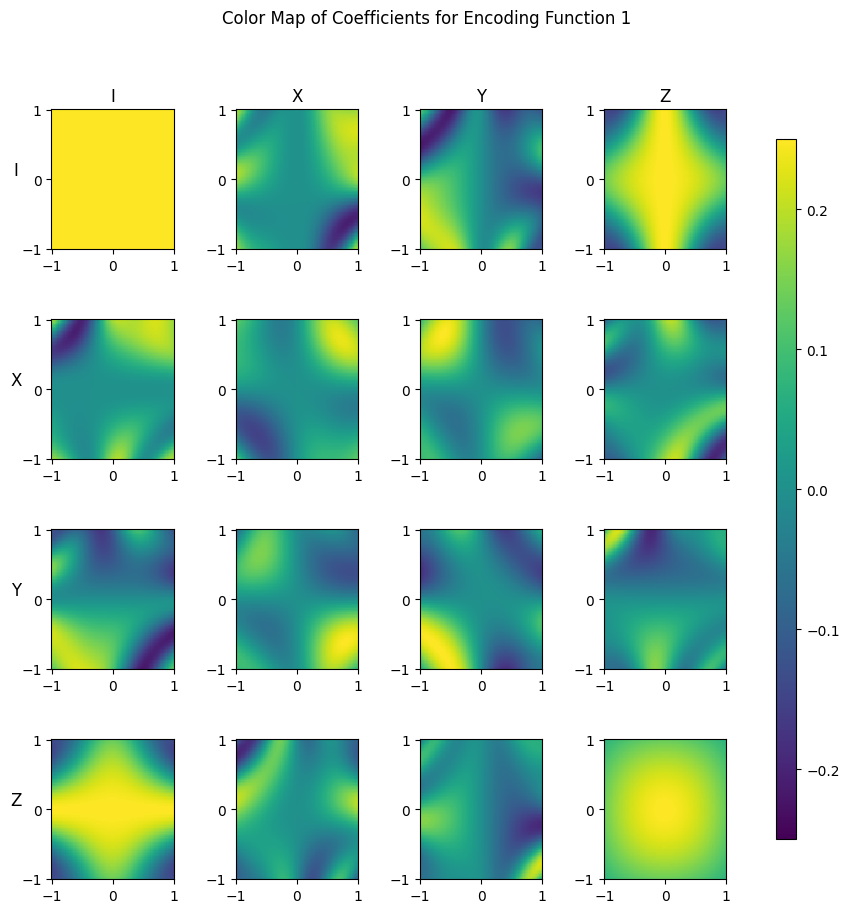

In [48]:
# Feature Map 1
fm1_x12s_grid = encoding_fns['encoding_fn_1'] (x1s_grid, x2s_grid)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in np.arange(4):
    for j in np.arange(4):
        idx = i*4 + j
        pauli_matrix = list(coefficients.keys())[idx]
        aixs = coefficients[pauli_matrix](x1s_grid, x2s_grid, fm1_x12s_grid)
        heatmap = axs[i, j].pcolor(x1s, x2s, aixs, vmin=-0.25, vmax=0.25)
        axs[i, j].set_xticks([-1, 0, 1])
        axs[i, j].set_yticks([-1, 0, 1])

        # Set some grid axes up
        if i == 0:
            axs[i, j].set_title(pauli_matrix[0])
        if j == 0:
            axs[i, j].set_ylabel(pauli_matrix[1], rotation=0, size='large')

fig.subplots_adjust(right=0.8, wspace=0.5, hspace=0.5)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)
fig.suptitle('Color Map of Coefficients for Encoding Function 1')


plt.show()


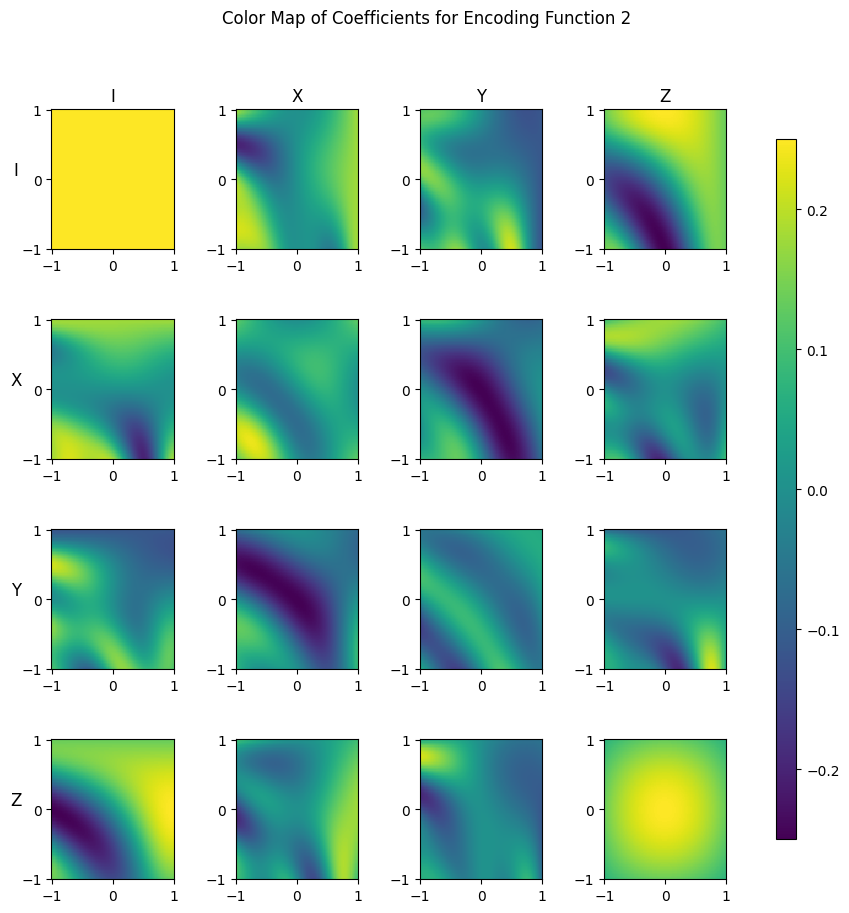

In [49]:
# Feature Map 2
fm2_x12s_grid = encoding_fns['encoding_fn_2'] (x1s_grid, x2s_grid)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in np.arange(4):
    for j in np.arange(4):
        idx = i*4 + j
        pauli_matrix = list(coefficients.keys())[idx]
        aixs = coefficients[pauli_matrix](x1s_grid, x2s_grid, fm2_x12s_grid)
        heatmap = axs[i, j].pcolor(x1s, x2s, aixs, vmin=-0.25, vmax=0.25)
        axs[i, j].set_xticks([-1, 0, 1])
        axs[i, j].set_yticks([-1, 0, 1])

        # Set some grid axes up
        if i == 0:
            axs[i, j].set_title(pauli_matrix[0])
        if j == 0:
            axs[i, j].set_ylabel(pauli_matrix[1], rotation=0, size='large')

fig.subplots_adjust(right=0.8, wspace=0.5, hspace=0.5)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)
fig.suptitle('Color Map of Coefficients for Encoding Function 2')


plt.show()

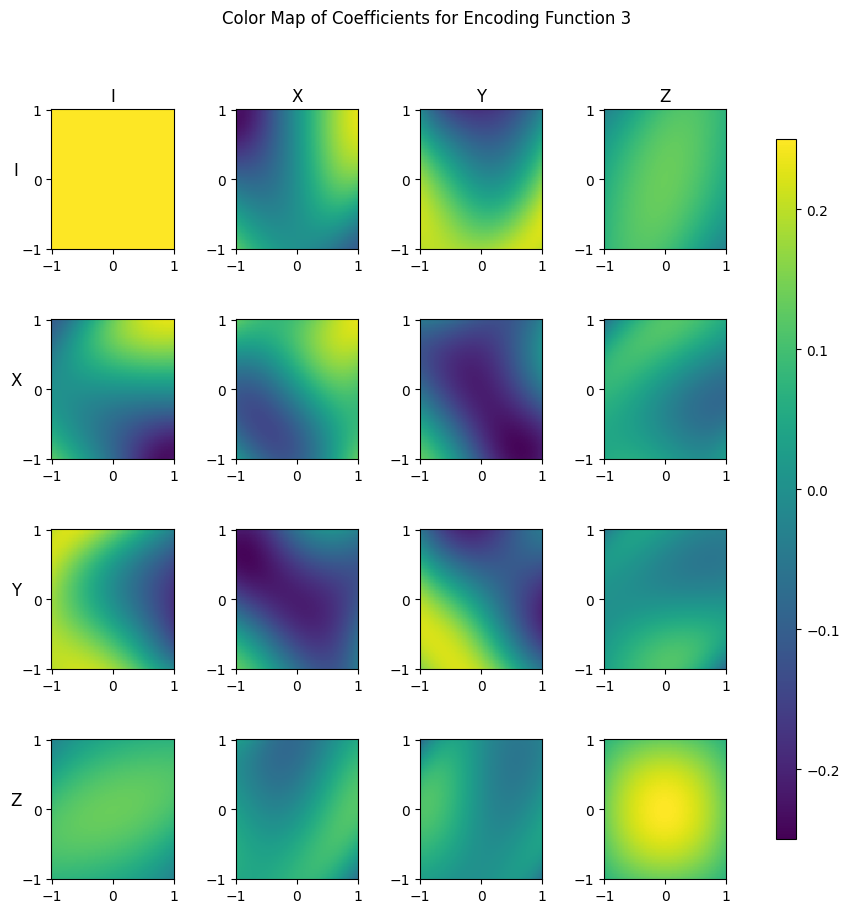

In [50]:
# Feature Map 3
fm3_x12s_grid = encoding_fns['encoding_fn_3'] (x1s_grid, x2s_grid)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in np.arange(4):
    for j in np.arange(4):
        idx = i*4 + j
        pauli_matrix = list(coefficients.keys())[idx]
        aixs = coefficients[pauli_matrix](x1s_grid, x2s_grid, fm3_x12s_grid)
        heatmap = axs[i, j].pcolor(x1s, x2s, aixs, vmin=-0.25, vmax=0.25)
        axs[i, j].set_xticks([-1, 0, 1])
        axs[i, j].set_yticks([-1, 0, 1])

        # Set some grid axes up
        if i == 0:
            axs[i, j].set_title(pauli_matrix[0])
        if j == 0:
            axs[i, j].set_ylabel(pauli_matrix[1], rotation=0, size='large')

fig.subplots_adjust(right=0.8, wspace=0.5, hspace=0.5)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)
fig.suptitle('Color Map of Coefficients for Encoding Function 3')


plt.show()

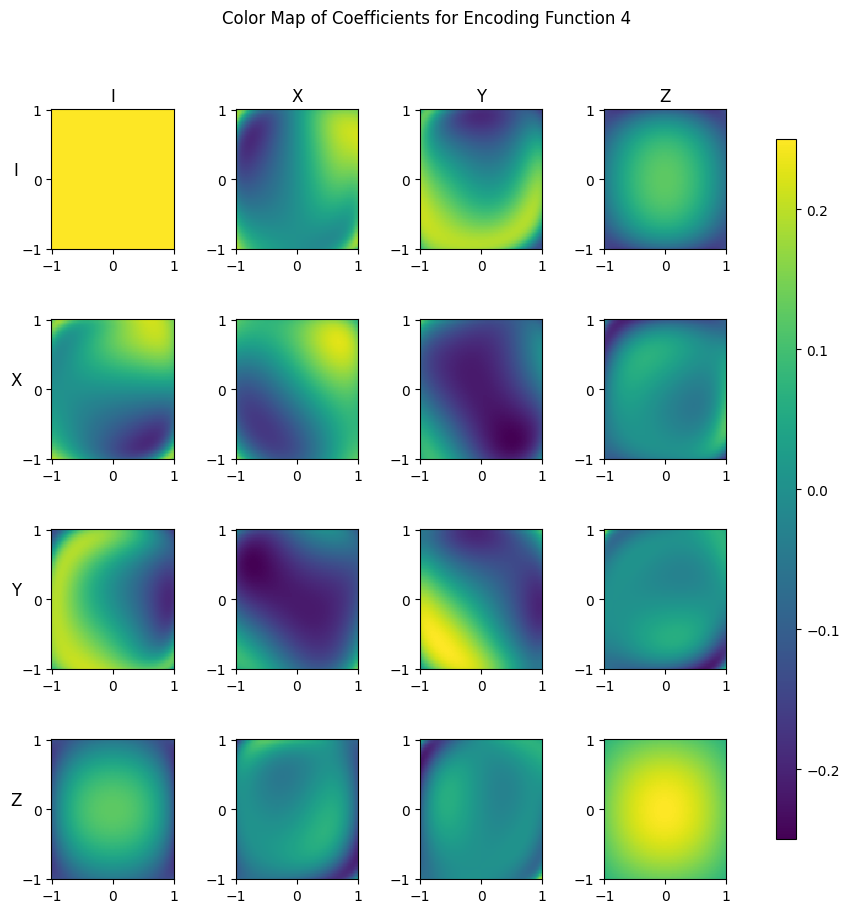

In [51]:
# Feature Map 4
fm4_x12s_grid = encoding_fns['encoding_fn_4'] (x1s_grid, x2s_grid)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in np.arange(4):
    for j in np.arange(4):
        idx = i*4 + j
        pauli_matrix = list(coefficients.keys())[idx]
        aixs = coefficients[pauli_matrix](x1s_grid, x2s_grid, fm4_x12s_grid)
        heatmap = axs[i, j].pcolor(x1s, x2s, aixs, vmin=-0.25, vmax=0.25)
        axs[i, j].set_xticks([-1, 0, 1])
        axs[i, j].set_yticks([-1, 0, 1])

        # Set some grid axes up
        if i == 0:
            axs[i, j].set_title(pauli_matrix[0])
        if j == 0:
            axs[i, j].set_ylabel(pauli_matrix[1], rotation=0, size='large')

fig.subplots_adjust(right=0.8, wspace=0.5, hspace=0.5)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)
fig.suptitle('Color Map of Coefficients for Encoding Function 4')


plt.show()

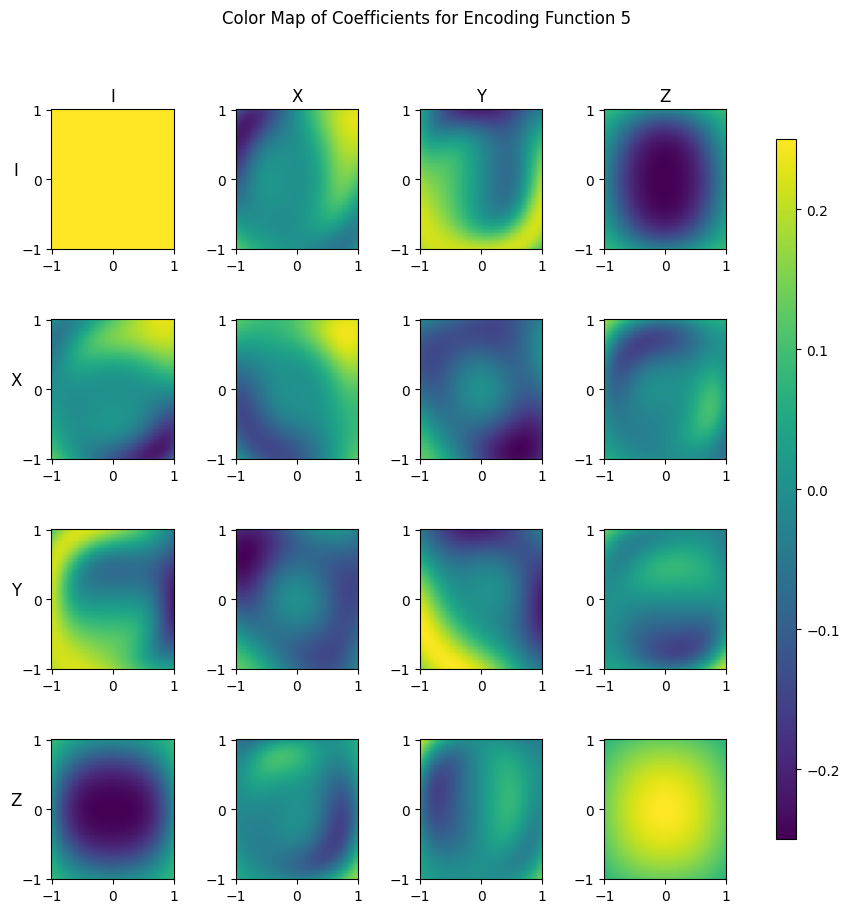

In [52]:
# Feature Map 5
fm5_x12s_grid = encoding_fns['encoding_fn_5'] (x1s_grid, x2s_grid)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in np.arange(4):
    for j in np.arange(4):
        idx = i*4 + j
        pauli_matrix = list(coefficients.keys())[idx]
        aixs = coefficients[pauli_matrix](x1s_grid, x2s_grid, fm5_x12s_grid)
        heatmap = axs[i, j].pcolor(x1s, x2s, aixs, vmin=-0.25, vmax=0.25)
        axs[i, j].set_xticks([-1, 0, 1])
        axs[i, j].set_yticks([-1, 0, 1])

        # Set some grid axes up
        if i == 0:
            axs[i, j].set_title(pauli_matrix[0])
        if j == 0:
            axs[i, j].set_ylabel(pauli_matrix[1], rotation=0, size='large')

fig.subplots_adjust(right=0.8, wspace=0.5, hspace=0.5)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)
fig.suptitle('Color Map of Coefficients for Encoding Function 5')


plt.show()

## References

1. https://arxiv.org/pdf/1906.10467.pdf